In [24]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
# setup cell to make our lives easier 
import re
import numpy as np
import os
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import glob
from utils import *
from eval_script import *
from customize_dataset import DexNetNPZDataset
from customize_dataset import DexNetNPZDatasetAll

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

tensor_dir = '../../dexnet_2.1/dexnet_2.1_eps_50/tensors/'  # replace with actual path
batch_size = 32
use_regression = False  # or True
pose_dims = [0, 1, 2, 3, 4, 5]
device = "cpu" # torch.device("cuda" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
use_regression = False
depth_files = sorted(glob.glob(os.path.join(tensor_dir, "depth_ims_tf_table_*.npz")))
hand_pose_files = sorted(glob.glob(os.path.join(tensor_dir, "hand_poses_*.npz")))
label_files = sorted(glob.glob(os.path.join(tensor_dir, "labels_*.npz")))
metric_files = sorted(glob.glob(os.path.join(tensor_dir, "grasp_metrics_*.npz")))


In [28]:
class SimpleGQCNN(nn.Module):
    def __init__(self, pose_dim=4, output_type='binary', merge_methods="element_dot"):
        """
        pose_dim: number of dimensions in the pose vector (e.g., x, y, z, theta)
        output_type: 'binary' or 'regression'
        """
        super(SimpleGQCNN, self).__init__()
        self.output_type = output_type

        # Image stream
        self.conv1 = nn.Conv2d(1, 16, 3)           # → (B, 16, 30, 30)
        self.pool = nn.MaxPool2d(2, 2)             # → (B, 16, 15, 15)
        self.conv2 = nn.Conv2d(16, 32, 3)          # → (B, 32, 13, 13) → pool → (B, 32, 6, 6)
        self.im_fc = nn.Linear(32 * 6 * 6, 64)     # → (B, 64)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.im_fc_bn = nn.BatchNorm1d(64)

        # Pose stream
        self.pose_fc1 = nn.Linear(pose_dim, 64)
        self.pose_fc2 = nn.Linear(64, 64)
        self.dropout = nn.Dropout(p=0.5)
        self.merge_methods = merge_methods
        if self.merge_methods == "element_dot":
            # Merge stream after elementwise multiplication
            self.merge_fc1 = nn.Linear(64, 32)
            self.merge_fc2 = nn.Linear(32, 1)
        else:
            # Merge stream by concatanation
            self.merge_fc1 = nn.Linear(64 + 64, 64)
            self.merge_fc2 = nn.Linear(64, 1)  # Single output for binary or regression

    def forward(self, image, pose):
        
        # Image stream
        x = self.pool(F.relu(self.bn1(self.conv1(image))))   # (B, 16, 15, 15)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))       # (B, 32, 6, 6)
        # x = x.view(x.size(0), -1)                  # Flatten
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.im_fc(x))                  # (B, 64)

        # Pose stream
        p = self.dropout(F.relu(self.pose_fc1(pose)))            # (B, 64)
        p = self.dropout(F.relu(self.pose_fc2(p)))               # (B, 64)

        if self.merge_methods == "element_dot":
            # Element-wise multiplication
            combined = x * p                           # (B, 64)
        else:
            # Merge
            combined = torch.cat((x, p), dim=1)       # -> (B, 96)

        # Final layers
        out = F.relu(self.merge_fc1(combined))     # (B, 32)
        out = self.merge_fc2(out)                  # (B, 1)

        # if self.output_type == 'binary':
        #     out = torch.sigmoid(out)               # Binary prediction
        return out 


In [ ]:
def compute_obj_frequency_distrubtion(tensor_dir = "../../dexnet_2.1/dexnet_2.1_eps_50/tensors/"):  
    # Step 1: Load all obj_ids
    obj_id_files = sorted(glob.glob(os.path.join(tensor_dir, "grasped_obj_keys*.npz")))
    all_obj_ids = []

    for obj_id_file in obj_id_files:
        ids = np.load(obj_id_file)["arr_0"]  # shape: (N,)
        all_obj_ids.extend(ids.tolist())     # flatten and collect

    # Step 2: Count occurrences
    obj_id_counts = Counter(all_obj_ids)

    # Step 3: Visualize the distribution
    sorted_ids = sorted(obj_id_counts.keys())
    frequencies = [obj_id_counts[obj_id] for obj_id in sorted_ids]

    # Print summary
    print(f"🔢 Total unique object IDs: {len(obj_id_counts)}")
    print(f"📦 Total grasps counted: {len(all_obj_ids)}")

    # Now count how many objects appeared N times
    # This is a histogram of frequencies
    frequency_of_frequencies = Counter(obj_id_counts.values())

    # Sort bins by number of appearances
    sorted_bins = sorted(frequency_of_frequencies.keys())
    num_objects_in_bin = [frequency_of_frequencies[n] for n in sorted_bins]
    # grab the eps_xx part 
    match = re.search(r"eps_\d{2}", tensor_dir)
    if match:
        eps_part = match.group()
    # Plot histogram of object frequency bins
    plt.figure(figsize=(7, 5))
    plt.bar(sorted_bins, num_objects_in_bin, width=5)
    plt.xlabel("Number of Appearances (per Object ID)")
    plt.ylabel("Number of Object IDs")
    plt.title(f"Object Frequency Distribution For Dataset {eps_part}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return obj_id_counts

In [72]:
def test_accuracy_on_bin_frequencies(model, obj_id_counts,
                        tensor_dir="../../dexnet_2.1/dexnet_2.1_eps_10/tensors/",
                        use_regression=False):

    # Define your bins
    bin_edges = [0, 10, 20, 30, 40, 50, 60, 100, 500, 1000]
    bin_labels = [(bin_edges[i], bin_edges[i+1]) for i in range(len(bin_edges)-1)]

    # Build a lookup for obj_id → bin label
    def get_bin(freq):
        for low, high in bin_labels:
            if low <= freq < high:
                return f"[{low}-{high})"
        return "other"

    obj_id_to_bin = {obj_id: get_bin(count) for obj_id, count in obj_id_counts.items()}
    # File paths
    depth_files = sorted(glob.glob(os.path.join(tensor_dir, "depth_ims_tf_table_*.npz")))
    pose_files = sorted(glob.glob(os.path.join(tensor_dir, "hand_poses_*.npz")))
    label_files = sorted(glob.glob(os.path.join(tensor_dir, "labels_*.npz")))
    obj_key_files = sorted(glob.glob(os.path.join(tensor_dir, "grasped_obj_keys*.npz")))
    # Track accuracy per bin
    bin_results = defaultdict(lambda: {"correct": 0, "total": 0, "positive_samples": 0})

    model.eval()

    for i in range(len(depth_files)):
        depths = np.load(depth_files[i])["arr_0"]       # (N, 32, 32)
        poses = np.load(pose_files[i])["arr_0"]          # (N, pose_dim)
        labels = np.load(label_files[i])["arr_0"]        # (N,)
        obj_ids = np.load(obj_key_files[i])["arr_0"]     # (N,)

        for j in range(len(labels)):
            obj_id = obj_ids[j]
            bin_label = obj_id_to_bin.get(obj_id, "other")

            # Preprocess input
            depth = depths[j]
            if depth.ndim == 2:
                depth = depth[None, None, :, :]
            elif depth.ndim == 3:
                depth = depth.transpose(2, 0, 1)[None, ...]
            depth_tensor = torch.tensor(depth, dtype=torch.float32).to(device)
            pose_tensor = torch.tensor(poses[j], dtype=torch.float32).unsqueeze(0).to(device)
            label = labels[j]

            with torch.no_grad():
                output = model(depth_tensor, pose_tensor)
                if not use_regression:
                    output = torch.sigmoid(output)
                    prediction = (output >= 0.5).item()
                    correct = int(prediction == label)
                else:
                    prediction = output.item()
                    correct = int(np.isclose(prediction, label, atol=0.1))

            bin_results[bin_label]["correct"] += correct
            bin_results[bin_label]["total"] += 1
            bin_results[bin_label]["positive_samples"] += label

    # Print results
    print("\n🎯 Accuracy by Object Frequency Bin:")
    for bin_label in sorted(bin_results.keys()):
        correct = bin_results[bin_label]["correct"]
        total = bin_results[bin_label]["total"]
        acc = correct / total if total > 0 else 0.0
        bin_results[bin_label]["correct"] = acc
        bin_results[bin_label]["positive_samples"] = bin_results[bin_label]["positive_samples"] / total if total > 0 else 0.0
        print(f"  Bin {bin_label}: {acc*100:.2f}% ({correct}/{total}); positive samples: {bin_results[bin_label]["positive_samples"]*100:.2f}")
    
    bin_labels_sorted = sorted(bin_results.keys(), key=lambda b: int(b.split('-')[0][1:]))  # sort numerically
    accuracies = [
        bin_results[b]["correct"] 
        for b in bin_labels_sorted
    ]

    # grab the eps_xx part 
    match = re.search(r"eps_\d{2}", tensor_dir)
    if match:
        eps_part = match.group()
    plt.figure(figsize=(6, 5))
    plt.bar(bin_labels_sorted, [a * 100 for a in accuracies], color='skyblue')
    plt.xlabel("Object Frequency Bin (Appearances)")
    plt.ylabel("Accuracy (%)")
    plt.title(f"Model Accuracy vs. Object Frequency, Trained on {eps_part}")
    plt.ylim(50, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    return bin_results

🔢 Total unique object IDs: 1372
📦 Total grasps counted: 16466


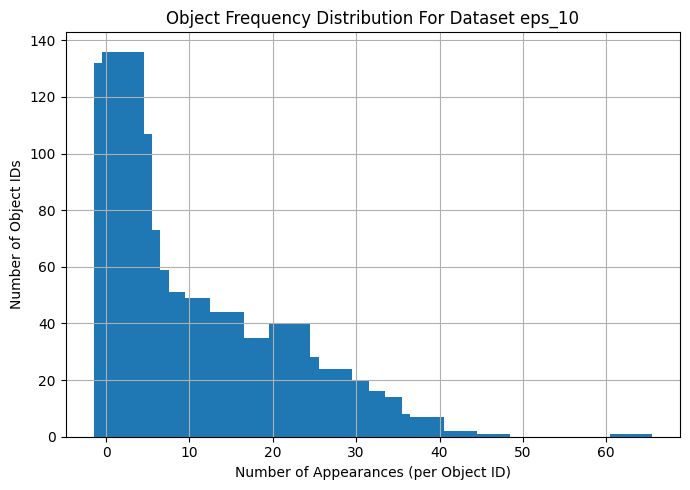


🎯 Accuracy by Object Frequency Bin:
  Bin [0-10): 82.58% (2142/2594); positive samples: 49.23
  Bin [10-20): 92.73% (4730/5101); positive samples: 90.02
  Bin [20-30): 95.55% (5756/6024); positive samples: 93.11
  Bin [30-40): 95.82% (2405/2510); positive samples: 93.31
  Bin [40-50): 97.70% (170/174); positive samples: 95.98
  Bin [60-100): 92.06% (58/63); positive samples: 82.54


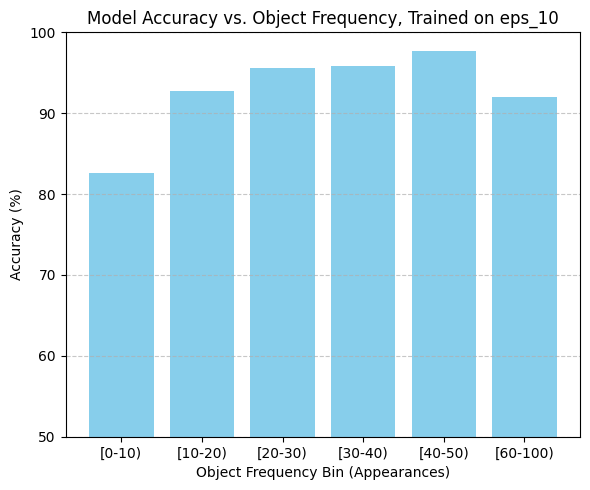

In [73]:
# load SimpleGQCNN model
# eps 10 
tensor_dir = '../../dexnet_2.1/dexnet_2.1_eps_10/tensors/'  # replace with actual path

model = SimpleGQCNN(pose_dim=len(pose_dims), output_type='regression' if use_regression else 'binary')
model.load_state_dict(torch.load("eps_10/model.pth", weights_only=False, map_location=torch.device('cpu')))
model = model.to(device, memory_format=torch.channels_last)

obj_id_counts = compute_obj_frequency_distrubtion(tensor_dir)
bin_results_10 = test_accuracy_on_bin_frequencies(model, obj_id_counts, tensor_dir)

🔢 Total unique object IDs: 1447
📦 Total grasps counted: 34804


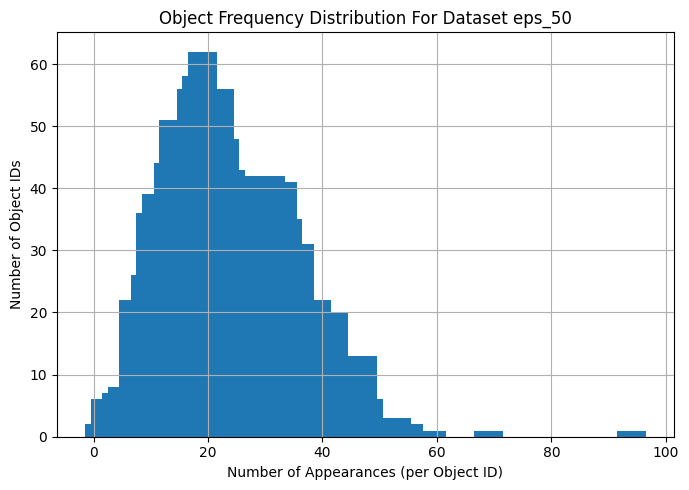


🎯 Accuracy by Object Frequency Bin:
  Bin [0-10): 91.00% (576/633); positive samples: 21.33
  Bin [10-20): 88.84% (6374/7175); positive samples: 20.46
  Bin [20-30): 85.71% (8828/10300); positive samples: 34.60
  Bin [30-40): 83.00% (8830/10638); positive samples: 50.86
  Bin [40-50): 82.63% (4171/5048); positive samples: 57.43
  Bin [50-60): 81.46% (690/847); positive samples: 59.62
  Bin [60-100): 86.50% (141/163); positive samples: 57.67


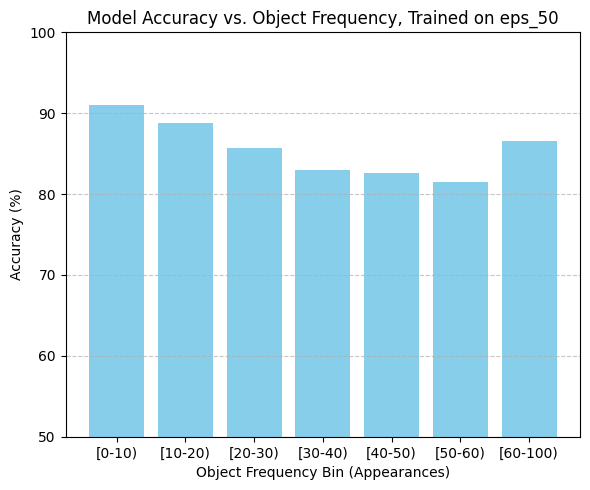

In [74]:
# load SimpleGQCNN model
# eps 50 
tensor_dir = '../../dexnet_2.1/dexnet_2.1_eps_50/tensors/'  # replace with actual path

model = SimpleGQCNN(pose_dim=len(pose_dims), output_type='regression' if use_regression else 'binary')
model.load_state_dict(torch.load("eps_50/model.pth", weights_only=False, map_location=torch.device('cpu')))
model = model.to(device, memory_format=torch.channels_last)

obj_id_counts = compute_obj_frequency_distrubtion(tensor_dir)
bin_results_50 = test_accuracy_on_bin_frequencies(model, obj_id_counts, tensor_dir)

🔢 Total unique object IDs: 1457
📦 Total grasps counted: 102565


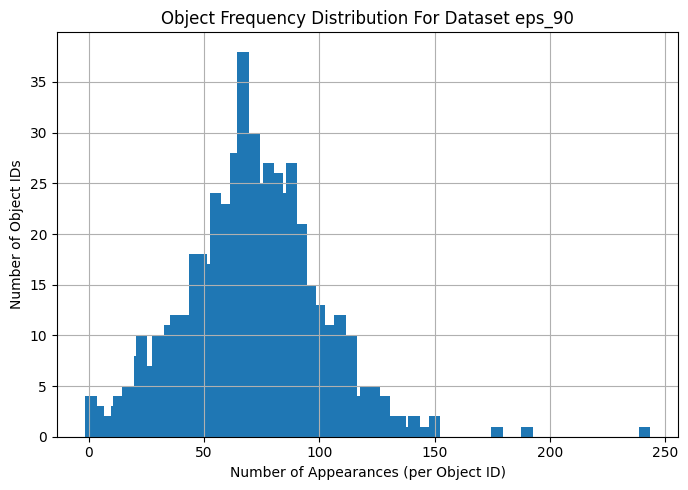


🎯 Accuracy by Object Frequency Bin:
  Bin [0-10): 95.95% (71/74); positive samples: 4.05
  Bin [10-20): 68.80% (258/375); positive samples: 31.20
  Bin [100-500): 94.77% (18691/19722); positive samples: 5.23
  Bin [20-30): 75.91% (983/1295); positive samples: 24.09
  Bin [30-40): 82.17% (2180/2653); positive samples: 17.83
  Bin [40-50): 84.58% (4699/5556); positive samples: 15.42
  Bin [50-60): 86.67% (8463/9765); positive samples: 13.33
  Bin [60-100): 90.50% (57125/63125); positive samples: 9.50


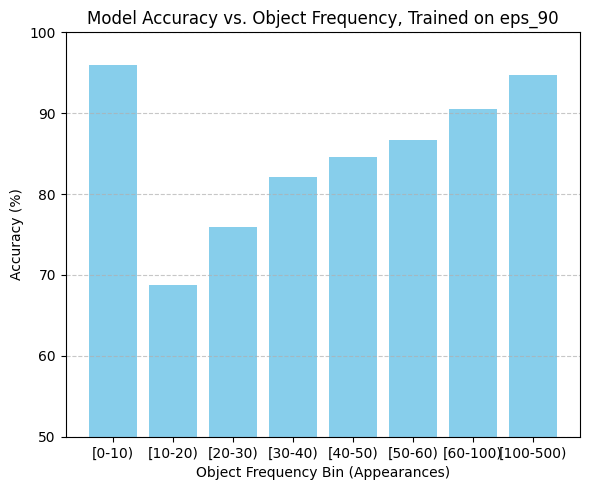

In [76]:
# load SimpleGQCNN model
# eps 90 
tensor_dir = '../../dexnet_2.1/dexnet_2.1_eps_90/tensors/'  # replace with actual path

model = SimpleGQCNN(pose_dim=len(pose_dims), output_type='regression' if use_regression else 'binary')
model.load_state_dict(torch.load("eps_90/model.pth", weights_only=False, map_location=torch.device('cpu')))
model = model.to(device, memory_format=torch.channels_last)

obj_id_counts = compute_obj_frequency_distrubtion(tensor_dir)
bin_results_90 = test_accuracy_on_bin_frequencies(model, obj_id_counts, tensor_dir)

In [80]:
accuracy = []
acc = [
    bin_results_10[b]["correct"] 
    for b in bin_results_10
]
accuracy.extend(acc)
acc = [
    bin_results_50[b]["correct"] 
    for b in bin_results_50
]
accuracy.extend(acc)
acc = [
    bin_results_90[b]["correct"] 
    for b in bin_results_90
]
accuracy.extend(acc)

positives = []
pos = [
    bin_results_10[b]["positive_samples"] 
    for b in bin_results_10
]
positives.extend(pos)
pos = [
    bin_results_50[b]["positive_samples"] 
    for b in bin_results_50
]
positives.extend(pos)
pos = [
    bin_results_90[b]["positive_samples"] 
    for b in bin_results_90
]
positives.extend(pos)

In [81]:
corr = np.corrcoef(accuracy, positives)[0, 1]
print(f"📈 Pearson Correlation: {corr:.4f}")


📈 Pearson Correlation: 0.3067
